In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from imblearn.datasets import make_imbalance
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

/Users/juliankleindiek/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


## Damage Models

**Purpose of this notebook:** In this notebook, we apply different machine learning and deep learning techniques to make predictions on the damage caused by severe weather events. The target variable will be a categorical variable created from `DAMAGE_PROPERTY` and `DAMAGE_CROPS`. We will use the feature engineered data resulting from previous notebooks.

Structure of this notebook:
1. Multiclass classification: We start by classifying multiple damage categories based on balanced as well as unbalanced data. We apply models such as SVM, KNN, Decision Trees, Random Forests, Gradient Boosting, and Ada Boosting and compare their performance respectively.
2. Binary classification: We then limit the number of classes to only 2 and again make classifications based on balanced as well as unbalanced data. We apply deep learning techniques such as Artificial Neural Networks and benchmark them against machine learning models such as Ada Boosting.

## 1. Data

In [2]:
# load data
dat = pd.read_csv("datasets/dat_fe.csv", index_col="Unnamed: 0")

/Users/juliankleindiek/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/juliankleindiek/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
# display
dat.head()

,latitude,longitude,EVENT_TYPE,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,fraction_cloud_cover,...,fraction_cloud_cover_10_day_min,relative_humidity_10_day_min,temperature_10_day_min,u_component_wind_10_day_min,v_component_wind_10_day_min,vertical_velocity_10_day_min,geo_cluster,year,month,day
0,24.74,-124.779999,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,2015,1,4
1,24.74,-124.779999,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,7.532600,265.40286,-1.206722,-13.830118,0.329384,0,2015,1,5
2,24.74,-124.779999,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,7.532600,264.13422,-1.702287,-13.830118,0.310506,0,2015,1,6
3,24.74,-124.779999,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,7.018421,263.48780,-3.931420,-13.830118,-0.045236,0,2015,1,7
4,24.74,-124.779999,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,7.018421,261.52145,-3.931420,-13.830118,-0.089284,0,2015,1,8


In [4]:
# create column for total damage
dat["total_damage"] = dat["DAMAGE_PROPERTY"] + dat["DAMAGE_CROPS"]

# find rows where total damage is not null
total_damage_not_null = dat[dat["total_damage"] != 0]

# find info on not null damage
total_damage_not_null["total_damage"].describe()

count    2.318900e+04
mean     3.627052e+06
std      1.354412e+08
min      1.000000e+01
25%      4.000000e+03
50%      1.500000e+04
75%      6.400000e+04
max      1.200291e+10
Name: total_damage, dtype: float64

## 2. Multiclass Classification

### 2.1. Creating Classes

The following cut-off points are defined having our insurance business use case in mind as well as trying to find a reasonable distribution of classes.

In [6]:
# define ranges for damage classes
bin_labels = ["no_damage", "small_damage", "considerable_damage", "high_damage", "catastrophic_damage"]
cut_bins = [-1, 1, 15000, 100000, 1000000, float(dat[["total_damage"]].max())]

# assign damage classes
dat["damage_class"] = pd.cut(dat["total_damage"], bins=cut_bins, labels=bin_labels)

# investigate resulting bins
dat["damage_class"].value_counts()

no_damage              3753905
small_damage             12045
considerable_damage       6713
high_damage               3223
catastrophic_damage       1208
Name: damage_class, dtype: int64

In [7]:
# insight into events by damage class
print(dat[dat.damage_class == "catastrophic_damage"]["EVENT_TYPE"].value_counts())
print(dat[dat.damage_class == "small_damage"]["EVENT_TYPE"].value_counts())

Flood                       306
Flash Flood                 283
Thunderstorm Wind           237
Hail                        163
Tornado                     133
Heavy Rain                   55
Marine Thunderstorm Wind     16
Lightning                    15
Name: EVENT_TYPE, dtype: int64
Thunderstorm Wind           7275
Flash Flood                 1450
Hail                        1370
Flood                        987
Lightning                    361
Tornado                      247
Marine Thunderstorm Wind     233
Heavy Rain                   122
Name: EVENT_TYPE, dtype: int64


In [8]:
# drop event columns
dat = dat.drop(columns=["EVENT_TYPE"]).copy()

# drop nans 
dat.dropna(inplace=True)

In [9]:
# split into train and test; not random but by time
dat_train = dat[dat["year"] < 2019].copy()
dat_test = dat[dat["year"] >= 2019].copy()

In [10]:
# train and test split
print("{:.2f}% of the data are used for training, representing {} year(s).".format(len(dat_train)/len(dat), len(dat_train["year"].unique())))
print("{:.2f}% of the data are used for testing, representing {} year(s).".format(len(dat_test)/len(dat), len(dat_test["year"].unique())))

0.80% of the data are used for training, representing 4 year(s).
0.20% of the data are used for testing, representing 1 year(s).


In [11]:
# drop first 10 days from testing for each location as they include information from training
dat_test = dat_test[(dat_test["month"] != 1) & (dat_test["day"] > 10)]

In [12]:
# select features for train
X_train = dat_train.drop(columns=["INJURIES_DIRECT", "INJURIES_INDIRECT", "DEATHS_DIRECT", "DEATHS_INDIRECT",
                                  "DAMAGE_PROPERTY", "DAMAGE_CROPS", "total_damage", "damage_class"]).copy().values

# select features for test
X_test = dat_test.drop(columns=["INJURIES_DIRECT", "INJURIES_INDIRECT", "DEATHS_DIRECT", "DEATHS_INDIRECT",
                                "DAMAGE_PROPERTY", "DAMAGE_CROPS", "total_damage", "damage_class"]).copy().values

In [13]:
# select target variable
y_train = dat_train[["damage_class"]].copy().values.ravel()
y_test = dat_test[["damage_class"]].copy().values.ravel()

### 2.2. Sampling and Balance

### - make_imbalance
- See: https://imbalanced-learn.readthedocs.io/en/stable/auto_examples/applications/plot_multi_class_under_sampling.html

In [12]:
# investigate balance in train
print(pd.Series(y_train).value_counts()/len(y_train)*100)

no_damage              99.395467
small_damage            0.315555
considerable_damage     0.173386
high_damage             0.084970
catastrophic_damage     0.030621
dtype: float64


In [13]:
# balance train dataset
X_train_bal, y_train_bal = make_imbalance(X_train, y_train, sampling_strategy={"no_damage": int(len(y_train)*0.01)}, 
                                          random_state=3)

In [14]:
print(pd.Series(y_train_bal).value_counts()/len(y_train_bal)*100)

no_damage              62.323151
small_damage           19.666646
considerable_damage    10.806122
high_damage             5.295661
catastrophic_damage     1.908421
dtype: float64


### - smote
- See: https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html

In [34]:
# initialize smote
smote_over = SMOTE(sampling_strategy="all")

# balance train dataset
X_train_smote, y_train_smote = smote_over.fit_resample(X_train, y_train)

In [35]:
print(pd.Series(y_train_smote).value_counts()/len(y_train_smote)*100)

no_damage              20.0
high_damage            20.0
considerable_damage    20.0
catastrophic_damage    20.0
small_damage           20.0
dtype: float64


### 2.3. Modelling `damage_class`

### - Support Vector Machine Base Model

In [ ]:
# initiate StandardScaler()
scaler = StandardScaler()

# fit scaler using training data
scaler.fit(X_train_bal)

# transform data
x_train_scaled = scaler.transform(X_train_bal)
x_test_scaled = scaler.transform(X_test)

In [22]:
# instantiatie model
svc = svm.SVC(kernel="rbf", random_state=3)

# fit the model
svc.fit(x_train_scaled, y_train_bal)

# predict on test data
y_pred_test_svc = svc.predict(x_test_scaled)

# predict on train data
y_pred_train_svc = svc.predict(x_train_scaled)

In [ ]:
# save model object to disk
filename = 'models/damage_class_svm.sav'
pickle.dump(svc, open(filename, 'wb'))

In [24]:
# classification report
print(classification_report(y_test, y_pred_test_svc))

                     precision    recall  f1-score   support

catastrophic_damage       0.00      0.00      0.00       187
considerable_damage       0.01      0.00      0.00      1035
        high_damage       0.00      0.00      0.00       470
          no_damage       1.00      0.94      0.97    460170
       small_damage       0.03      0.46      0.05      1721

           accuracy                           0.93    463583
          macro avg       0.21      0.28      0.20    463583
       weighted avg       0.99      0.93      0.96    463583



In [26]:
# classification report
print(classification_report(y_train_bal, y_pred_train_svc))

                     precision    recall  f1-score   support

catastrophic_damage       0.78      0.05      0.09       924
considerable_damage       0.52      0.02      0.04      5232
        high_damage       0.79      0.02      0.05      2564
          no_damage       0.79      0.93      0.86     30175
       small_damage       0.49      0.65      0.56      9522

           accuracy                           0.71     48417
          macro avg       0.67      0.33      0.32     48417
       weighted avg       0.70      0.71      0.65     48417



In [29]:
# confusion matrix
labels = [i for i in np.unique(y_test)]
df = confusion_matrix(y_test, y_pred_test_svc, labels=labels)
pd.DataFrame(df, index=labels, columns=labels)

,catastrophic_damage,considerable_damage,high_damage,no_damage,small_damage
catastrophic_damage,0,1,0,148,38
considerable_damage,0,1,0,624,410
high_damage,0,0,0,347,123
no_damage,8,73,15,431833,28241
small_damage,0,2,1,928,790


**Comments:**
- The SVM base model is quite unstable and is not able to classify damage in the test data. The high accuracy results from the class imbalance of this dataset. 

### - KNN Base Model

In [32]:
# initialize knn
knn = KNeighborsClassifier()

# fit knn
knn.fit(x_train_scaled, y_train_bal)

# make predictions on x_test
y_pred_test_knn = knn.predict(x_test_scaled)

# make predictions on x_train
y_pred_train_knn = knn.predict(x_train_scaled)

In [37]:
# save model object to disk
filename = 'models/damage_class_knn.sav'
pickle.dump(knn, open(filename, 'wb'))

In [33]:
# classification report
print(classification_report(y_test, y_pred_test_knn))

                     precision    recall  f1-score   support

catastrophic_damage       0.00      0.03      0.00       187
considerable_damage       0.01      0.20      0.01      1035
        high_damage       0.00      0.04      0.00       470
          no_damage       1.00      0.83      0.90    460170
       small_damage       0.01      0.29      0.02      1721

           accuracy                           0.82    463583
          macro avg       0.20      0.28      0.19    463583
       weighted avg       0.99      0.82      0.90    463583



In [34]:
# classification report
print(classification_report(y_train_bal, y_pred_train_knn))

                     precision    recall  f1-score   support

catastrophic_damage       0.45      0.44      0.45       924
considerable_damage       0.47      0.56      0.51      5232
        high_damage       0.47      0.39      0.43      2564
          no_damage       0.91      0.90      0.90     30175
       small_damage       0.66      0.63      0.65      9522

           accuracy                           0.78     48417
          macro avg       0.59      0.59      0.59     48417
       weighted avg       0.78      0.78      0.78     48417



In [36]:
# confusion matrix
labels = [i for i in np.unique(y_test)]
df = confusion_matrix(y_test, y_pred_test_knn, labels=labels)
pd.DataFrame(df, index=labels, columns=labels)

,catastrophic_damage,considerable_damage,high_damage,no_damage,small_damage
catastrophic_damage,5,31,13,98,40
considerable_damage,14,203,38,522,258
high_damage,4,70,21,267,108
no_damage,2505,29618,8174,380886,38987
small_damage,21,313,55,827,505


**Comments:**
- The KNN base model is farily stable with a test accuracy that is higher than the training accuracy. This is many due to the fact that the KNN model is actually able to make decent classifications on the train data also for the minority classes. The model doesn't gerneralize well unfortunately and is not able to classify the minority classes well on the test data.

### - Decision Tree Base Model

In [154]:
# initialize decision tree
dt = DecisionTreeClassifier(random_state=3)

# fit decision tree
dt.fit(X_train_bal, y_train_bal)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=3, splitter='best')

In [155]:
# make predictions on x_test
y_pred_test = dt.predict(X_test_bal)

# make predictions on x_train
y_pred_train = dt.predict(X_train_bal)

# predict probabilites test
y_pred_proba_test = dt.predict_proba(X_test_bal)

# predict probabilites train
y_pred_proba_train = dt.predict_proba(X_train_bal)

In [157]:
# classification report
print(classification_report(y_test_bal, y_pred_test))

                     precision    recall  f1-score   support

catastrophic_damage       0.01      0.01      0.01       187
considerable_damage       0.22      0.18      0.20      1035
        high_damage       0.10      0.09      0.09       470
          no_damage       0.77      0.82      0.79      4635
       small_damage       0.39      0.39      0.39      1721

           accuracy                           0.58      8048
          macro avg       0.30      0.30      0.30      8048
       weighted avg       0.56      0.58      0.57      8048



In [158]:
# classification report
print(classification_report(y_train_bal, y_pred_train))

                     precision    recall  f1-score   support

catastrophic_damage       1.00      1.00      1.00       924
considerable_damage       1.00      1.00      1.00      5232
        high_damage       1.00      1.00      1.00      2564
          no_damage       1.00      1.00      1.00     30175
       small_damage       1.00      1.00      1.00      9522

           accuracy                           1.00     48417
          macro avg       1.00      1.00      1.00     48417
       weighted avg       1.00      1.00      1.00     48417



In [163]:
# confusion matrix
labels = [i for i in np.unique(y_test_bal)]
df = confusion_matrix(y_test_bal, y_pred_test, labels=labels)
pd.DataFrame(df, index=labels, columns=labels)

,catastrophic_damage,considerable_damage,high_damage,no_damage,small_damage
catastrophic_damage,1,27,24,87,48
considerable_damage,33,187,99,351,365
high_damage,14,80,42,176,158
no_damage,42,218,121,3806,448
small_damage,40,330,135,552,664


In [167]:
# confusion matrix
labels = [i for i in np.unique(y_train_bal)]
df = confusion_matrix(y_train_bal, y_pred_train, labels=labels)
pd.DataFrame(df, index=labels, columns=labels)

,catastrophic_damage,considerable_damage,high_damage,no_damage,small_damage
catastrophic_damage,924,0,0,0,0
considerable_damage,0,5232,0,0,0
high_damage,0,0,2564,0,0
no_damage,0,0,0,30175,0
small_damage,0,0,0,0,9522


**Comments:**
- Random Forest base model overfits drastically. The model is able to make classifications on small_damage and considerable_damage, but struggles with catastrophic_damage and high_damage classes. There might be not enough cases for those classes to properly train the model on them.

### - Random Forest Base Model (with class_weight)

In [29]:
# initialize decision tree
rf = RandomForestClassifier(class_weight="balanced", random_state=3)

# fit decision tree
rf.fit(X_train, y_train)

# make predictions on x_test
y_pred_test_rf = rf.predict(X_test)

# make predictions on x_train
y_pred_train_rf = rf.predict(X_train)

In [30]:
# save model object to disk
filename = 'models/damage_class_fr_class_weights.sav'
pickle.dump(rf, open(filename, 'wb'))

In [31]:
# classification report
print(classification_report(y_test, y_pred_test_rf))

                     precision    recall  f1-score   support

catastrophic_damage       0.00      0.00      0.00       187
considerable_damage       0.00      0.00      0.00      1035
        high_damage       0.00      0.00      0.00       470
          no_damage       0.62      0.99      0.77      5546
       small_damage       0.47      0.04      0.08      1721

           accuracy                           0.62      8959
          macro avg       0.22      0.21      0.17      8959
       weighted avg       0.48      0.62      0.49      8959



/Users/juliankleindiek/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
# classification report
print(classification_report(y_train, y_pred_train_rf))

                     precision    recall  f1-score   support

catastrophic_damage       1.00      1.00      1.00       924
considerable_damage       1.00      1.00      1.00      5232
        high_damage       1.00      1.00      1.00      2564
          no_damage       1.00      1.00      1.00     29425
       small_damage       1.00      1.00      1.00      9522

           accuracy                           1.00     47667
          macro avg       1.00      1.00      1.00     47667
       weighted avg       1.00      1.00      1.00     47667



In [33]:
# confusion matrix
labels = [i for i in np.unique(y_train)]
df = confusion_matrix(y_test, y_pred_test_rf, labels=labels)
pd.DataFrame(df, index=labels, columns=labels)

,catastrophic_damage,considerable_damage,high_damage,no_damage,small_damage
catastrophic_damage,0,0,0,187,0
considerable_damage,0,0,0,1006,29
high_damage,0,0,0,467,3
no_damage,0,0,0,5497,49
small_damage,0,0,0,1650,71


**Comments:**
- This Random Forest was fit with the class_weight set to "balanced". The performance of the model doesn't improve much.

### - Gradient Boosting Base Model

In [189]:
# initialize model
gradient = GradientBoostingClassifier()

# run grid search
gradient.fit(X_train_bal, y_train_bal)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [190]:
# save model object to disk
filename = 'models/damage_class_gradient.sav'
pickle.dump(gradient, open(filename, 'wb'))

In [191]:
# make predictions on x_test
y_pred_test_ggs = gradient.predict(X_test_bal)

# make predictions on x_train
y_pred_train_ggs = gradient.predict(X_train_bal)

# predict probabilites test
y_pred_proba_test_ggs = gradient.predict_proba(X_test_bal)

# predict probabilites train
y_pred_proba_train_ggs = gradient.predict_proba(X_train_bal)

In [192]:
# classification report
print(classification_report(y_test_bal, y_pred_test_ggs))

                     precision    recall  f1-score   support

catastrophic_damage       0.17      0.01      0.01       187
considerable_damage       0.26      0.02      0.04      1035
        high_damage       0.00      0.00      0.00       470
          no_damage       0.76      0.91      0.83      4635
       small_damage       0.47      0.65      0.55      1721

           accuracy                           0.67      8048
          macro avg       0.33      0.32      0.29      8048
       weighted avg       0.58      0.67      0.60      8048



In [193]:
# classification report
print(classification_report(y_train_bal, y_pred_train_ggs))

                     precision    recall  f1-score   support

catastrophic_damage       0.88      0.12      0.22       924
considerable_damage       0.41      0.05      0.09      5232
        high_damage       0.68      0.05      0.10      2564
          no_damage       0.80      0.92      0.86     30175
       small_damage       0.49      0.64      0.55      9522

           accuracy                           0.71     48417
          macro avg       0.65      0.36      0.36     48417
       weighted avg       0.69      0.71      0.66     48417



In [194]:
# confusion matrix
labels = [i for i in np.unique(y_test_bal)]
df = confusion_matrix(y_test_bal, y_pred_test_ggs, labels=labels)
pd.DataFrame(df, index=labels, columns=labels)

,catastrophic_damage,considerable_damage,high_damage,no_damage,small_damage
catastrophic_damage,1,5,2,115,64
considerable_damage,1,24,8,396,606
high_damage,2,22,0,240,206
no_damage,2,17,7,4219,390
small_damage,0,25,13,560,1123


In [195]:
# confusion matrix
labels = [i for i in np.unique(y_train_bal)]
df = confusion_matrix(y_train_bal, y_pred_train_ggs, labels=labels)
pd.DataFrame(df, index=labels, columns=labels)

,catastrophic_damage,considerable_damage,high_damage,no_damage,small_damage
catastrophic_damage,114,35,10,482,283
considerable_damage,1,268,27,2136,2800
high_damage,5,135,138,1217,1069
no_damage,6,102,15,27906,2146
small_damage,4,107,14,3330,6067


**Comments:**
- The Gradient Boosting base model is much more stable compared to the Random Forest base model. However, this model also struggles with detecting catastrophic_damage, considerable_damage, and hgih_damage cases.

### - Gradient Boosting Base Model (smote sampling)

In [43]:
# initialize model
gradient = GradientBoostingClassifier()

# run grid search
gradient.fit(X_train_smote, y_train_smote)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [44]:
# save model object to disk
filename = 'models/damage_class_gradient_smote.sav'
pickle.dump(gradient, open(filename, 'wb'))

In [45]:
# make predictions on x_test
y_pred_test_ggs = gradient.predict(X_test)

# make predictions on x_train
y_pred_train_ggs = gradient.predict(X_train_smote)

In [46]:
# classification report
print(classification_report(y_test, y_pred_test_ggs))

                     precision    recall  f1-score   support

catastrophic_damage       0.07      0.06      0.06       187
considerable_damage       0.23      0.09      0.13      1035
        high_damage       0.09      0.07      0.08       470
          no_damage       0.73      0.76      0.74      5546
       small_damage       0.37      0.48      0.41      1721

           accuracy                           0.58      8959
          macro avg       0.30      0.29      0.28      8959
       weighted avg       0.55      0.58      0.56      8959



In [47]:
# classification report
print(classification_report(y_train_smote, y_pred_train_ggs))

                     precision    recall  f1-score   support

catastrophic_damage       0.59      0.61      0.60     29425
considerable_damage       0.42      0.30      0.35     29425
        high_damage       0.46      0.39      0.42     29425
          no_damage       0.59      0.73      0.66     29425
       small_damage       0.42      0.49      0.45     29425

           accuracy                           0.50    147125
          macro avg       0.50      0.50      0.50    147125
       weighted avg       0.50      0.50      0.50    147125



In [48]:
# confusion matrix
labels = [i for i in np.unique(y_test)]
df = confusion_matrix(y_test, y_pred_test_ggs, labels=labels)
pd.DataFrame(df, index=labels, columns=labels)

,catastrophic_damage,considerable_damage,high_damage,no_damage,small_damage
catastrophic_damage,11,15,16,118,27
considerable_damage,22,90,60,453,410
high_damage,15,36,33,283,103
no_damage,83,169,193,4218,883
small_damage,38,90,59,714,820


**Comments:**
- Applying smote to balance the classes improves the accuracy of a Gradient Boosting model for classifying the minority classes. The overall performance declined.

### - Ada Boosting Base Model (smote sampling)

In [60]:
# initialize model
ada = AdaBoostClassifier()

# run grid search
ada.fit(X_train_smote, y_train_smote)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

In [61]:
# save model object to disk
filename = 'models/damage_class_ada_smote.sav'
pickle.dump(ada, open(filename, 'wb'))

In [62]:
# make predictions on x_test
y_pred_test_ada = ada.predict(X_test)

# make predictions on x_train
y_pred_train_ada = ada.predict(X_train_smote)

In [63]:
# classification report
print(classification_report(y_test, y_pred_test_ada))

                     precision    recall  f1-score   support

catastrophic_damage       0.03      0.06      0.04       187
considerable_damage       0.15      0.03      0.06      1035
        high_damage       0.08      0.20      0.11       470
          no_damage       0.73      0.56      0.63      5546
       small_damage       0.33      0.54      0.41      1721

           accuracy                           0.47      8959
          macro avg       0.26      0.28      0.25      8959
       weighted avg       0.54      0.47      0.48      8959



In [64]:
# classification report
print(classification_report(y_train_smote, y_pred_train_ada))

                     precision    recall  f1-score   support

catastrophic_damage       0.38      0.45      0.41     29425
considerable_damage       0.29      0.18      0.22     29425
        high_damage       0.28      0.20      0.23     29425
          no_damage       0.47      0.54      0.50     29425
       small_damage       0.34      0.45      0.38     29425

           accuracy                           0.36    147125
          macro avg       0.35      0.36      0.35    147125
       weighted avg       0.35      0.36      0.35    147125



In [65]:
# confusion matrix
labels = [i for i in np.unique(y_test)]
df = confusion_matrix(y_test, y_pred_test_ada, labels=labels)
pd.DataFrame(df, index=labels, columns=labels)

,catastrophic_damage,considerable_damage,high_damage,no_damage,small_damage
catastrophic_damage,11,6,53,78,39
considerable_damage,45,36,136,365,453
high_damage,28,15,93,207,127
no_damage,278,129,708,3112,1319
small_damage,59,48,161,518,935


**Comments:**
- Since Ada Boosting changes the weights for misclassified observations when fitting models sequentially, we also wanted to test that model, but Ada Boosting performs worse than Gradient Boosting on the data balanced with smote.

## 3. Binary Classification

### 3.1. Creating Classes

The following cut-off points are defined having our insurance business use case in mind as well as trying to find a reasonable distribution of classes.

In [5]:
# define ranges for damage classes
bin_labels = [0, 1]
cut_bins = [-1, 10000, float(dat[["total_damage"]].max())]

# assign damage classes
dat["damage_class"] = pd.cut(dat["total_damage"], bins=cut_bins, labels=bin_labels)

# investigate resulting bins
dat["damage_class"].value_counts()

0    3764505
1      12589
Name: damage_class, dtype: int64

In [6]:
# drop event columns
dat = dat.drop(columns=["EVENT_TYPE"]).copy()

# drop nas
dat.dropna(inplace=True)

In [7]:
# split into train and test; not random but by time
dat_train = dat[dat["year"] < 2019].copy()
dat_test = dat[dat["year"] >= 2019].copy()

In [8]:
# train and test split
print("{:.2f}% of the data are used for training, representing {} year(s).".format(len(dat_train)/len(dat), len(dat_train["year"].unique())))
print("{:.2f}% of the data are used for testing, representing {} year(s).".format(len(dat_test)/len(dat), len(dat_test["year"].unique())))

0.80% of the data are used for training, representing 4 year(s).
0.20% of the data are used for testing, representing 1 year(s).


In [9]:
# drop first 10 days from testing for each location as they include information from training
dat_test = dat_test[(dat_test["month"] != 1) & (dat_test["day"] > 10)]

In [10]:
# select features for train
X_train = dat_train.drop(columns=["INJURIES_DIRECT", "INJURIES_INDIRECT", "DEATHS_DIRECT", "DEATHS_INDIRECT",
                                  "DAMAGE_PROPERTY", "DAMAGE_CROPS", "total_damage", "damage_class"]).copy().values

# select features for test
X_test = dat_test.drop(columns=["INJURIES_DIRECT", "INJURIES_INDIRECT", "DEATHS_DIRECT", "DEATHS_INDIRECT",
                                "DAMAGE_PROPERTY", "DAMAGE_CROPS", "total_damage", "damage_class"]).copy().values

In [11]:
# select target variable
y_train = dat_train[["damage_class"]].copy().values.ravel()
y_test = dat_test[["damage_class"]].copy().values.ravel()

### 3.2. Sampling and Balance

In [12]:
SEED=3

# define oversampling strategy
over = RandomOverSampler(sampling_strategy=0.1, random_state=SEED)

# fit and apply the transform
X_train_bal, y_train_bal = over.fit_resample(X_train, y_train)
print(Counter(y_train_bal))

# define undersampling strategy
under = RandomUnderSampler(random_state=SEED)

# fit and apply the transform
X_train_bal, y_train_bal = under.fit_resample(X_train_bal, y_train_bal)
print(Counter(y_train_bal))

#X_train_bal, y_train_bal = under.fit_resample(X_train, y_train)
#print(Counter(y_train_bal))

Counter({0: 3007677, 1: 300767})
Counter({0: 300767, 1: 300767})


### 3.3. Modelling `damage_class`

### - Artificial Neural Network - Unbalanced

In [23]:
# define shapes
input_shape = X_train.shape[1]
output_shape = 1

In [24]:
# define the keras model
model = Sequential()
model.add(Dense(12, input_dim=input_shape, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(output_shape, activation='sigmoid'))

In [25]:
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
# model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 12)                444       
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 9         
Total params: 557
Trainable params: 557
Non-trainable params: 0
_________________________________________________________________


In [49]:
# fit model
history = model.fit(X_train, y_train, validation_split=0.25, epochs=3, batch_size=128)

Train on 2263152 samples, validate on 754384 samples
Epoch 1/3
2263152/2263152 [==============================] - 49s 22us/step - loss: 0.0254 - accuracy: 0.9962 - val_loss: 0.0144 - val_accuracy: 0.9982
Epoch 2/3
2263152/2263152 [==============================] - 53s 23us/step - loss: 0.0246 - accuracy: 0.9962 - val_loss: 0.0135 - val_accuracy: 0.9982
Epoch 3/3
2263152/2263152 [==============================] - 59s 26us/step - loss: 0.0241 - accuracy: 0.9962 - val_loss: 0.0126 - val_accuracy: 0.9982


In [19]:
# evaluate model
print('\n# Evaluate on test data')
results = model.evaluate(X_test, y_test, batch_size=128)
print("test loss: {}, test acc: {}.".format(results[0], results[1]))


# Evaluate on test data
463583/463583 [==============================] - 4s 8us/step
test loss: 0.026431621275406405, test acc: 0.9958820939064026.


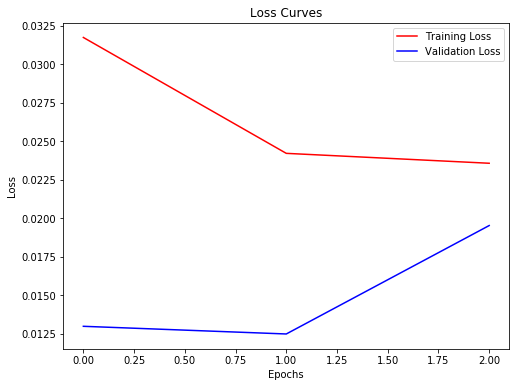

In [20]:
# plot loss curves
plt.figure(figsize=[8,6])
plt.plot(history.history["loss"], "r")
plt.plot(history.history["val_loss"], "b")
plt.legend(["Training Loss", "Validation Loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.show()

In [21]:
# make predictions
y_pred_test_ann = model.predict_classes(X_test)
y_pred_train_ann = model.predict_classes(X_train)

In [22]:
# classification report
print(classification_report(y_test, y_pred_test_ann))

/Users/juliankleindiek/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    461674
           1       0.00      0.00      0.00      1909

    accuracy                           1.00    463583
   macro avg       0.50      0.50      0.50    463583
weighted avg       0.99      1.00      0.99    463583



In [23]:
# classification report
print(classification_report(y_train, y_pred_train_ann))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   3007677
           1       0.00      0.00      0.00      9859

    accuracy                           1.00   3017536
   macro avg       0.50      0.50      0.50   3017536
weighted avg       0.99      1.00      1.00   3017536



**Comments**:
- The model completely ignores the positive cases and is not able to properly classify.

### - Artificial Neural Network - Balanced Data

In [41]:
pd.Series(y_train_bal).value_counts()

1    300767
0    300767
dtype: int64

In [42]:
# define shapes
input_shape = X_train.shape[1]
print(input_shape)

output_shape = 1

36


In [43]:
# define the keras model
model = Sequential()
model.add(Dense(12, input_dim=input_shape, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(output_dim=output_shape, activation='sigmoid'))

/Users/juliankleindiek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=1)`
  """


In [44]:
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])

In [45]:
# model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 12)                444       
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 557
Trainable params: 557
Non-trainable params: 0
_________________________________________________________________


In [46]:
# fit model
history = model.fit(X_train_bal, y_train_bal, validation_split=0.25, epochs=3, batch_size=128)

Train on 451150 samples, validate on 150384 samples
Epoch 1/3
451150/451150 [==============================] - 8s 18us/step - loss: 1.2716 - accuracy: 0.6651 - val_loss: 1.4738 - val_accuracy: 0.1636
Epoch 2/3
451150/451150 [==============================] - 8s 17us/step - loss: 0.5811 - accuracy: 0.6968 - val_loss: 0.7049 - val_accuracy: 0.6378
Epoch 3/3
451150/451150 [==============================] - 7s 16us/step - loss: 0.5637 - accuracy: 0.7014 - val_loss: 0.4232 - val_accuracy: 0.8368


In [47]:
# evaluate model
print('\n# Evaluate on test data')
results = model.evaluate(X_test, y_test, batch_size=128)
print("test loss: {}, test acc: {}.".format(results[0], results[1]))


# Evaluate on test data
463583/463583 [==============================] - 4s 8us/step
test loss: 0.7065858916696801, test acc: 0.5814449787139893.


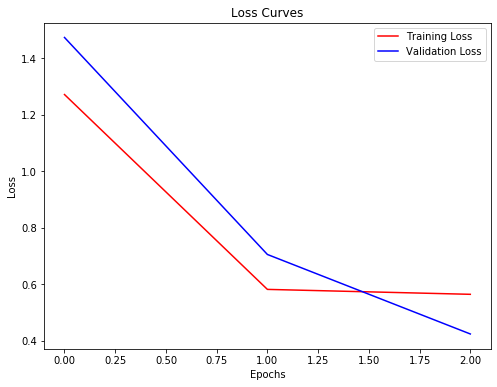

In [48]:
# plot loss curves
plt.figure(figsize=[8,6])
plt.plot(history.history["loss"], "r")
plt.plot(history.history["val_loss"], "b")
plt.legend(["Training Loss", "Validation Loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.show()

In [49]:
# make predictions
y_pred_test_ann_bal = model.predict_classes(X_test)
y_pred_train_ann_bal = model.predict_classes(X_train_bal)

In [50]:
# classification report
print(classification_report(y_test, y_pred_test_ann_bal))

              precision    recall  f1-score   support

           0       1.00      0.58      0.73    461674
           1       0.01      0.84      0.02      1909

    accuracy                           0.58    463583
   macro avg       0.50      0.71      0.38    463583
weighted avg       0.99      0.58      0.73    463583



In [51]:
# classification report
print(classification_report(y_train_bal, y_pred_train_ann_bal))

              precision    recall  f1-score   support

           0       0.78      0.57      0.66    300767
           1       0.66      0.84      0.74    300767

    accuracy                           0.70    601534
   macro avg       0.72      0.70      0.70    601534
weighted avg       0.72      0.70      0.70    601534



In [53]:
# confusion matrix
labels = [i for i in np.unique(y_test)]
df = confusion_matrix(y_test, y_pred_test_ann_bal, labels=labels)
pd.DataFrame(df, index=labels, columns=labels)

,0,1
0,267938,193736
1,299,1610


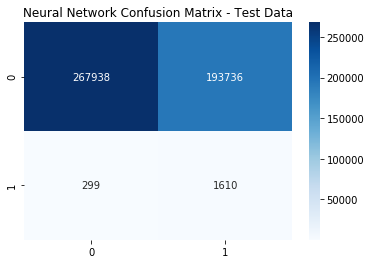

In [52]:
# test data Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test_ann_bal)

# plotting heatmap confusion matrix
sns.heatmap(cm, annot=True, 
                cmap='Blues',fmt="d").set_title(
    'Neural Network Confusion Matrix - Test Data')
plt.show()

**Comments:**
- The ANN performs much better on the balanced data and is actually predicting positive and negative cases. It only struggles with precision on the test data.

### - Ada Boosting - Balanced Data

In [35]:
# initialize model
ada = AdaBoostClassifier()

# run grid search
ada.fit(X_train_bal, y_train_bal)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

In [37]:
# make predictions on x_test
y_pred_test_ada_bal = ada.predict(X_test)

# make predictions on x_train
y_pred_train_ada_bal = ada.predict(X_train_bal)

In [38]:
# classification report
print(classification_report(y_test, y_pred_test_ada_bal))

              precision    recall  f1-score   support

           0       1.00      0.77      0.87    461674
           1       0.01      0.85      0.03      1909

    accuracy                           0.77    463583
   macro avg       0.51      0.81      0.45    463583
weighted avg       1.00      0.77      0.87    463583



In [39]:
# classification report
print(classification_report(y_train_bal, y_pred_train_ada_bal))

              precision    recall  f1-score   support

           0       0.81      0.77      0.79    300767
           1       0.78      0.82      0.80    300767

    accuracy                           0.79    601534
   macro avg       0.80      0.79      0.79    601534
weighted avg       0.80      0.79      0.79    601534



In [40]:
# confusion matrix
labels = [i for i in np.unique(y_test)]
df = confusion_matrix(y_test, y_pred_test_ada_bal, labels=labels)
pd.DataFrame(df, index=labels, columns=labels)

,0,1
0,355635,106039
1,295,1614


**Comments:**
- The Ada Boost Classifiert outperforms the Neural Network in this case.
- The accuracy on the training ad test data is decent. It only struggles with precision on the prediction of damage as it predicts to many cases with damage where there actually are none.
- We believe one reason to be the lack of relevant features. One example is any indication on how high damage could be based on the location of the event. The model has no insight into that and hence struggles to predict damage.
- Recall in this case is more important, because we want to detect the events that actually happened.

### - Ada Boosting Grid Search - Balanced Data

In [36]:
#create a dictionary of parameters 
params = {"n_estimators": [25, 50, 100, 150],
          "learning_rate":[0.5, 0.8, 1.0]}

# initialize model
ada_gs = AdaBoostClassifier(random_state=3)

# initialize grid search
ada_grid_search = RandomizedSearchCV(estimator=ada_gs, param_distributions=params, cv=3, scoring="roc_auc", n_jobs=-1, refit=True, verbose=3)

# run grid search
ada_grid_search.fit(X_train_bal, y_train_bal)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 39.9min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                                base_estimator=None,
                                                learning_rate=1.0,
                                                n_estimators=50,
                                                random_state=3),
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributions={'learning_rate': [0.5, 0.8, 1.0],
                                        'n_estimators': [25, 50, 100, 150]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='roc_auc', verbose=3)

In [37]:
# identify best parameter
print("The best parameters are:", ada_grid_search.best_params_)

# save model to disk
filename = 'models/damage_binary_ada_boosting_grid_search.sav'
pickle.dump(ada_grid_search, open(filename, 'wb'))

The best parameters are: {'n_estimators': 150, 'learning_rate': 1.0}


In [25]:
# load model from disk
filename = 'models/damage_binary_ada_boosting_grid_search.sav'
ada_grid_search = pickle.load(open(filename, 'rb'))

In [26]:
# make predictions on x_test
y_pred_test_ada_bal = ada_grid_search.best_estimator_.predict(X_test)

# make predictions on x_train
y_pred_train_ada_bal = ada_grid_search.best_estimator_.predict(X_train_bal)

In [39]:
# classification report
print(classification_report(y_test, y_pred_test_ada_bal))

              precision    recall  f1-score   support

           0       1.00      0.78      0.88    461674
           1       0.02      0.83      0.03      1909

    accuracy                           0.78    463583
   macro avg       0.51      0.81      0.45    463583
weighted avg       1.00      0.78      0.88    463583



In [40]:
# classification report
print(classification_report(y_train_bal, y_pred_train_ada_bal))

              precision    recall  f1-score   support

           0       0.82      0.78      0.80    300767
           1       0.79      0.83      0.81    300767

    accuracy                           0.80    601534
   macro avg       0.80      0.80      0.80    601534
weighted avg       0.80      0.80      0.80    601534



In [41]:
# confusion matrix
labels = [i for i in np.unique(y_test)]
df = confusion_matrix(y_test, y_pred_test_ada_bal, labels=labels)
pd.DataFrame(df, index=labels, columns=labels)

,0,1
0,361900,99774
1,315,1594


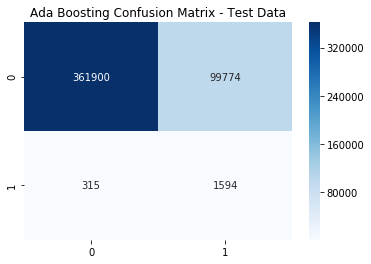

In [28]:
# test data Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test_ada_bal)

# plotting heatmap confusion matrix
sns.heatmap(cm, annot=True, 
                cmap='Blues',fmt="d").set_title(
    'Ada Boosting Confusion Matrix - Test Data')
plt.show()

**Comments:**
- Grid search leads to slight improvements in accuracy at the cost of slightly lower recall for severe events. But we also increased precision slightly. This represents a satisfactory model.

### - Gradient Boosting Grid Search - Balanced Data

In [27]:
#create a dictionary of parameters 
params = {"n_estimators": [50, 100, 120],
          "max_features":[5, 10, 15, 20],
          "max_depth":[6, 8, 10], 
          "min_samples_split":[80, 100, 120]}

# initialize decision tree
gb_gs = GradientBoostingClassifier(random_state=3)

# initialize grid search
gb_grid_search = RandomizedSearchCV(estimator=gb_gs, param_distributions=params, cv=5, scoring="roc_auc", n_jobs=-1, refit=True, verbose=3)

# run grid search
gb_grid_search.fit(X_train_bal, y_train_bal)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 68.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 136.8min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                        criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                    

In [30]:
# identify best parameter
print("The best parameters are:", gb_grid_search.best_params_)

# save model to disk
filename = 'models/damage_binary_gradient_boosting_grid_search.sav'
pickle.dump(gb_grid_search, open(filename, 'wb'))

# load model from disk
filename = 'models/damage_binary_gradient_boosting_grid_search.sav'
tst = pickle.load(open(filename, 'rb'))

The best parameters are: {'n_estimators': 120, 'min_samples_split': 100, 'max_features': 15, 'max_depth': 10}


In [29]:
# make predictions on x_test
y_pred_test_gb_bal = gb_grid_search.best_estimator_.predict(X_test)

# make predictions on x_train
y_pred_train_gb_bal = gb_grid_search.best_estimator_.predict(X_train_bal)

In [31]:
# classification report
print(classification_report(y_test, y_pred_test_gb_bal))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96    461674
           1       0.03      0.55      0.06      1909

    accuracy                           0.93    463583
   macro avg       0.51      0.74      0.51    463583
weighted avg       0.99      0.93      0.96    463583



In [32]:
# classification report
print(classification_report(y_train_bal, y_pred_train_gb_bal))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97    300767
           1       0.94      1.00      0.97    300767

    accuracy                           0.97    601534
   macro avg       0.97      0.97      0.97    601534
weighted avg       0.97      0.97      0.97    601534



In [34]:
# confusion matrix
labels = [i for i in np.unique(y_test)]
df = confusion_matrix(y_test, y_pred_test_gb_bal, labels=labels)
pd.DataFrame(df, index=labels, columns=labels)

,0,1
0,428342,33332
1,856,1053


**Comments:**:
- Chose to use Ada Boosting as the recall is higher and we are focused on recall